In [ ]:
# somehting I came upon https://towardsdatascience.com/going-beyond-simple-error-analysis-of-ml-systems-9218f9602d33

In [ ]:
# All inclusive modeling notebook

1. XGBoost:
    1. data pipelines
    2. baseline model 
    3. tpot 
    4. learning curves and xgboost default 
    5. grid search cv 
    6. hyperopt 
    7. output table with mse, rmse, r2, mae, Quantile of Errors, MAPE, RMSLE, RRSE, RAE

In [223]:
import numpy as np 
import seaborn as sns 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
import xgboost as xgb
import time
from sklearn.model_selection import GridSearchCV, KFold
from yellowbrick.regressor import residuals_plot, prediction_error
from fast_ml.model_development import train_valid_test_split
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from tpot import TPOTRegressor


In [2]:
project_name = '5. Used Car'
base_dir = 'D:/Projects/Prediction/Techniques Practice/Trees/XGBoost'
temp_dir = base_dir + '/' + project_name + '/' + 'temp data' + '/'
temp_dir

'D:/Projects/Prediction/Techniques Practice/Trees/XGBoost/5. Used Car/temp data/'

In [273]:
used_car_df = pd.read_csv(temp_dir + 'used_car_df.csv')
used_car_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115472 entries, 0 to 115471
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   model         115472 non-null  object 
 1   year          115472 non-null  float64
 2   price         115472 non-null  float64
 3   transmission  115472 non-null  object 
 4   mileage       115472 non-null  float64
 5   fuelType      115472 non-null  object 
 6   tax           115472 non-null  float64
 7   mpg           115472 non-null  float64
 8   engineSize    115472 non-null  float64
 9   make          115472 non-null  object 
dtypes: float64(6), object(4)
memory usage: 8.8+ MB


In [9]:
categorical_features = used_car_df.select_dtypes(include=['object']).columns
for ft in categorical_features:
    print('Categorical feature: {} has {} unique vals'.format(ft,used_car_df[ft].unique().shape[0]))

Categorical feature: model has 195 unique vals
Categorical feature: transmission has 4 unique vals
Categorical feature: fuelType has 5 unique vals
Categorical feature: make has 13 unique vals


In [16]:
#instead of using fancy encoding techniques I kind of want to run a random forest or lasso regression to see which levels we can drop 


In [15]:
# model has too many levels for one hot. and maybe make as well. 
used_car_df.model.value_counts().tail(80)

 CLA Class    86
 Hilux        85
 Beetle       83
 Puma         79
 M Class      79
              ..
180            1
230            1
220            1
200            1
 Accent        1
Name: model, Length: 80, dtype: int64

<AxesSubplot:>

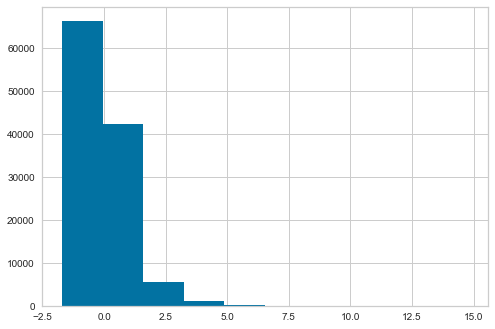

In [10]:
#lol. duh. using standard scaling for such a skewed distribution is literally just silly. 
pd.Series(StandardScaler().fit_transform(used_car_df[['price']]).flatten()).hist()

<AxesSubplot:>

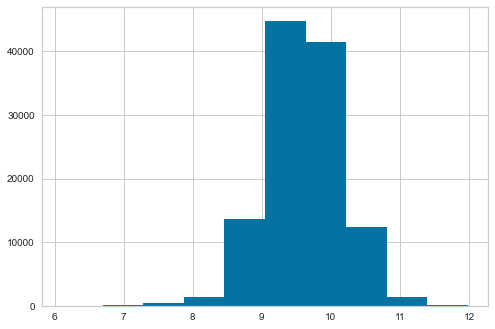

In [11]:
pd.Series(np.log(used_car_df.price)).hist()

16938.054065054734

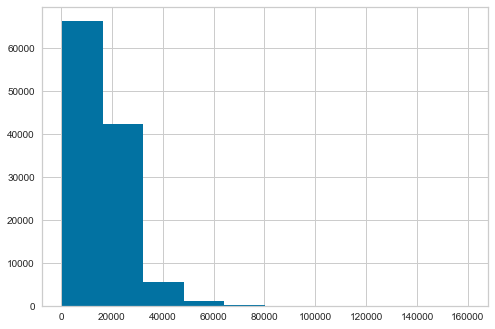

In [98]:
used_car_df.price.hist()
used_car_df.price.mean()

# PREPROCESSING PIPELINE

In [17]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import category_encoders as ce
import time
import warnings
encoders = {

    'JamesSteinEncoder': ce.james_stein.JamesSteinEncoder,
    'OneHotEncoder': ce.one_hot.OneHotEncoder,
    
}


dict_keys(['JamesSteinEncoder', 'OneHotEncoder'])

In [26]:
max_levels = round(used_car_df.columns.shape[0]*0.5)
categorical_features = used_car_df.select_dtypes(exclude=[np.number]).columns
cats_many = []
cats_few = []
for ft in categorical_features:
    levels = used_car_df[ft].unique().shape[0]
    if levels > max_levels:
        cats_many.append(ft)
    else:
        cats_few.append(ft)



In [274]:
#note: in all the data cleaning stuff, we really pay attention to missing data and as such some of the filling missing data steps are just like cautionary/good practice
numeric_features = used_car_df.select_dtypes([np.number]).drop(['price'], axis=1).columns
numeric_features

categorical_features = used_car_df.select_dtypes(exclude=[np.number]).columns
categorical_features

X = used_car_df.drop('price', axis=1)
y = used_car_df['price']

y = np.log(y)

X_train, X_test_tmp, y_train, y_test_tmp = train_test_split(X, y, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_test_tmp, y_test_tmp, test_size=0.5)

del X_test_tmp, y_test_tmp

selected_model = XGBRegressor(tree_method = "gpu_hist",single_precision_histogram=True, gpu_id=0)

encoders = {

    'JamesSteinEncoder': ce.james_stein.JamesSteinEncoder,
    'OneHotEncoder': ce.one_hot.OneHotEncoder,
    
}


categorical_transformer_many_level = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('encoder', encoders['JamesSteinEncoder']())
    ]
)    

categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('encoder', encoders['OneHotEncoder']())
    ]
) 

numeric_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numeric_transformer, numeric_features),
        ('categorical_many', categorical_transformer_many_level, cats_many),
        ('categorical', categorical_transformer, cats_few)
    ]
)

pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('regressor', selected_model)
    ]
)


In [94]:
#feature_names = list(preprocessor.transformers_[0][1][1].get_feature_names_out())+list( preprocessor.transformers_[1][2])

pipe.named_steps['preprocessor'].fit(X_train,y_train)

    
numeric_feat_names = pipe.named_steps['preprocessor'].transformers_[0][2]
cat_feat_names = pipe.named_steps['preprocessor'].transformers_[1][2]
redo_names = pipe.named_steps['preprocessor'].transformers_[2][1].named_steps['encoder'].get_feature_names()
base_names = pipe.named_steps['preprocessor'].transformers_[2][2]   
one_hot_feat_names=[]
for i in range(len(base_names)):
    one_hot_feat_names.append([base_names[i]+'_'+x.split('_')[-1] for x in redo_names if x[0] == str(i)])
    
feature_names = list(numeric_feat_names) + list(cat_feat_names) + [y for x in one_hot_feat_names for y in x]

In [343]:
feature_names = list(numeric_feat_names) + list(cat_feat_names) + [y for x in one_hot_feat_names for y in x]
len(feature_names)

16

In [100]:
import numpy as np

def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [139]:
# working with unscaled measures as it becomes much easier to work with
# also note: all measure on test, never on val. 
used_car_df_results = pd.DataFrame(columns=['model', 'rmse', 'r2', 'mape'])

## BASELINE

In [108]:
##### ##### ##### BASELINE ##### ##### #####
pred = [y_train.mean()]*len(y_val)
score = np.sqrt(mse(y_val, pred))
print('SCALED RMSE BASELINE: %.3f' % score)

pred = [np.exp(y_train).mean()]*len(y_test)
baseline_rmse = np.sqrt(mse(np.exp(y_test), pred))
baseline_r2_score = r2_score(np.exp(y_test), pred)
baseline_mape = mape(np.exp(y_test), pred)
print('RMSE TEST BASELINE: %.3f' % baseline_rmse)


SCALED RMSE BASELINE: 0.525
RMSE TEST BASELINE: 9719.772


In [140]:
row_template = {'model': '', 'rmse': 0, 'r2': 0, 'mape': 0}
row_to_insert = row_template.copy()
row_to_insert['model'] = 'Baseline'
row_to_insert['rmse'] = baseline_rmse
row_to_insert['r2'] = baseline_r2_score
row_to_insert['mape'] = baseline_mape
used_car_df_results = used_car_df_results.append(row_to_insert, ignore_index=True)
used_car_df_results

model        rmse        r2       mape
0  Baseline  9719.77206 -0.000135  56.541225

In [137]:
#give unscaled values
def populate_results_df(y_test, y_pred, model, used_car_df_results):
    y_test_unscaled = np.exp(y_test)
    y_pred_unscaled = np.exp(y_pred)
    row_to_insert['model'] = model
    row_to_insert['rmse'] = np.sqrt(mse(y_test_unscaled, y_pred_unscaled))
    row_to_insert['r2'] = r2_score(y_test_unscaled, y_pred_unscaled)
    row_to_insert['mape'] = mape(y_test_unscaled, y_pred_unscaled)
    used_car_df_results = used_car_df_results.append(row_to_insert, ignore_index=True)
    return used_car_df_results

## DEFAULTS XGB

In [275]:
preprocessor.fit(X_train, y_train)
X_train_prc = preprocessor.transform(X_train)
X_val_prc = preprocessor.transform(X_val)
X_test_prc = preprocessor.transform(X_test)
evalset = [(X_train_prc, y_train), (X_val_prc,y_val)]
selected_model.fit(X_train_prc, y_train, eval_metric='rmse', eval_set=evalset, verbose=0)

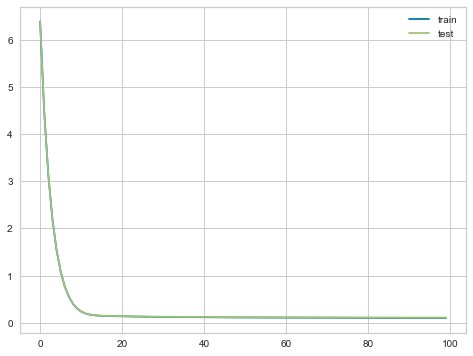

In [122]:
results = selected_model.evals_result()

plt.figure(figsize=(8,6))
# plot learning curves
plt.plot(results['validation_0']['rmse'], label='train')
plt.plot(results['validation_1']['rmse'], label='test')
plt.legend()
plt.show()

In [ ]:
#early stopping @5. 

In [141]:
y_pred_ = selected_model.predict(X_test_prc)
used_car_df_results = populate_results_df(y_test, y_pred_, 'defaults XGBReg', used_car_df_results)
used_car_df_results

model         rmse        r2       mape
0         Baseline  9719.772060 -0.000135  56.541225
1  defaults XGBReg  2376.507359  0.940211   8.086443

In [ ]:
# model has GINORMOUS improvement over baseline. yay. 

## BASIC GRIDSEARCH

In [142]:
# BASIC TUNE PARAMS 

start_time=time.time()

# grid search
xgb_reg = xgb.XGBRegressor(tree_method = "gpu_hist",single_precision_histogram=True, gpu_id=0)

param_grid = {
        'max_depth': [6, 9, 12],
        'learning_rate': [0.03, 0.05, 0.07],
        'n_estimators':[1500, 1800, 2100],
                               }

kfold = KFold(n_splits=3, shuffle=True, random_state=10)
grid_search = GridSearchCV(xgb_reg, param_grid, scoring="neg_root_mean_squared_error", cv=kfold)
grid_result = grid_search.fit(X_train_prc, y_train, verbose=0)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_[ 'mean_test_score' ]
stds = grid_result.cv_results_[ 'std_test_score' ]
params = grid_result.cv_results_[ 'params' ]

print(time.time()-start_time)

Best: -0.104599 using {'learning_rate': 0.07, 'max_depth': 6, 'n_estimators': 2100}
4912.054926395416


In [144]:
model = xgb.XGBRegressor(tree_method = "gpu_hist",single_precision_histogram=True, gpu_id=0, **grid_result.best_params_)
model.fit(X_train_prc,y_train)
y_pred_ = model.predict(X_test_prc)
used_car_df_results = populate_results_df(y_test, y_pred_, 'GridSearchCV XGBReg', used_car_df_results)
used_car_df_results

model         rmse        r2       mape
0             Baseline  9719.772060 -0.000135  56.541225
1      defaults XGBReg  2376.507359  0.940211   8.086443
2  GridSearchCV XGBReg  2180.355340  0.949673   7.184241

In [ ]:
# Okay effing great. Tuning becomes more relevant with dataset size. Obviously. 

## Tuning with regularization: hyperopt 

In [155]:
space={ 'eta' : 0.07 ,
        'max_depth': hp.quniform("max_depth", 5, 16, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'seed': 0
    }

def objective(space):
   
    clf=xgb.XGBRegressor(max_depth = int(space['max_depth']),learning_rate=space['eta'], gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']), tree_method = "gpu_hist",single_precision_histogram=True, gpu_id=0)
    evaluation = [( X_train_prc, y_train), ( X_val_prc, y_val)]
    
    clf.fit(X_train_prc, y_train,
    eval_set=evaluation, eval_metric="rmse",
    early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test_prc)
    accuracy = np.sqrt(mse(y_test, pred))
    print ("RMSE:", accuracy)
    return {'loss': accuracy, 'status': STATUS_OK }

In [156]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 1000,
                        trials = trials)

RMSE:                                                                                                                  
0.29012179998681814                                                                                                    
RMSE:                                                                                                                  
0.2898273229407439                                                                                                     
RMSE:                                                                                                                  
0.27672327271510994                                                                                                    
RMSE:                                                                                                                  
0.2798357364156973                                                                                                     
RMSE:                                   

In [159]:
best_hyperparams['max_depth'] = int(best_hyperparams['max_depth'])


In [163]:
model = xgb.XGBRegressor(tree_method = "gpu_hist",single_precision_histogram=True, gpu_id=0, **best_hyperparams)
model.fit(X_train_prc,y_train)
y_pred_ = model.predict(X_test_prc)
used_car_df_results = populate_results_df(y_test, y_pred_, 'Hyperopt XGBReg', used_car_df_results)
used_car_df_results

model         rmse        r2       mape
0             Baseline  9719.772060 -0.000135  56.541225
1      defaults XGBReg  2376.507359  0.940211   8.086443
2  GridSearchCV XGBReg  2180.355340  0.949673   7.184241
3      Hyperopt XGBReg  3489.333523  0.871106  11.288053

In [171]:
import optuna
def objective(trial):
    
    param = {
        'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimators': 4000,
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17,20]),
        'random_state': trial.suggest_categorical('random_state', [24, 48,2020]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }
    model = xgb.XGBRegressor(**param)  
    
    model.fit(X_train_prc,y_train,eval_set=[(X_val_prc,y_val)],early_stopping_rounds=100,verbose=False)
    
    preds = model.predict(X_test_prc)
    
    rmse = mse(y_test, preds,squared=False)
    
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
study.trials_dataframe()


[I 2022-01-25 17:39:32,571] A new study created in memory with name: no-name-063a89e8-2b50-46cc-a3a8-c68daf7bc1b7
[I 2022-01-25 17:41:46,855] Trial 0 finished with value: 0.114010498659434 and parameters: {'lambda': 0.023241275008692656, 'alpha': 0.023040688896137775, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.012, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 76}. Best is trial 0 with value: 0.114010498659434.
[I 2022-01-25 17:43:07,896] Trial 1 finished with value: 0.11625606249282439 and parameters: {'lambda': 0.04343883395683702, 'alpha': 0.056329395801494854, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.016, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 132}. Best is trial 0 with value: 0.114010498659434.
[I 2022-01-25 17:43:26,380] Trial 2 finished with value: 0.13331438090399425 and parameters: {'lambda': 0.19203539655404347, 'alpha': 0.13723007765692743, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.02,

XGBoostError: bad allocation

In [173]:
best_trial_params = {'lambda': 0.00854598912331914, 'alpha': 0.03733591935784401, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.009, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 6}
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
study.trials_dataframe().tail()

Number of finished trials: 45
Best trial: {'lambda': 0.00854598912331914, 'alpha': 0.03733591935784401, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.009, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 6}


number     value             datetime_start          datetime_complete  \
40      40  0.121263 2022-01-25 18:39:29.081176 2022-01-25 18:40:00.063538   
41      41  0.105867 2022-01-25 18:40:00.065538 2022-01-25 18:42:15.885750   
42      42  0.107385 2022-01-25 18:42:15.887750 2022-01-25 18:44:05.683493   
43      43  0.107863 2022-01-25 18:44:05.685491 2022-01-25 18:44:42.415466   
44      44       NaN 2022-01-25 18:44:42.417467 2022-01-25 18:49:06.929235   

                 duration  params_alpha  params_colsample_bytree  \
40 0 days 00:00:30.982362      0.040020                      0.3   
41 0 days 00:02:15.820212      0.013731                      0.5   
42 0 days 00:01:49.795743      0.030243                      0.5   
43 0 days 00:00:36.729975      0.066265                      0.9   
44 0 days 00:04:24.511768      0.008080                      0.5   

    params_lambda  params_learning_rate  params_max_depth  \
40       0.041016                 0.009                 9   
41       0.025568                 0.009                13   
42       0.009541                 0.009                13   
43       0.118231                 0.009                 7   
44       0.025022                 0.008                13   

    params_min_child_weight  params_random_state  params_subsample     state  
40                       87                   48               0.7  COMPLETE  
41                       17                   48               1.0  COMPLETE  
42                       27                   48               1.0  COMPLETE  
43                       13                   48               1.0  COMPLETE  
44                        1                 2020               1.0      FAIL

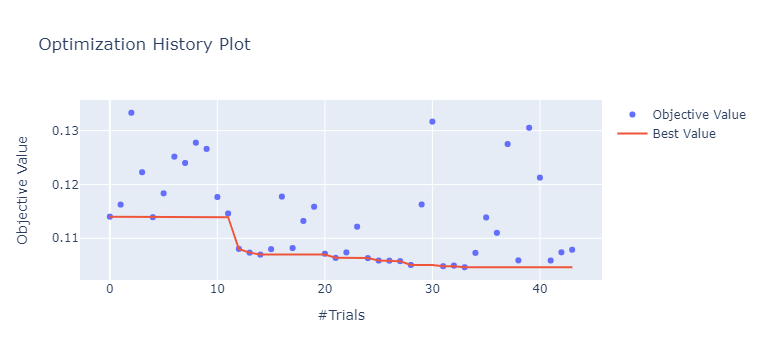

In [176]:
#plot_optimization_histor: shows the scores from all trials as well as the best score so far at each point.
optuna.visualization.plot_optimization_history(study)

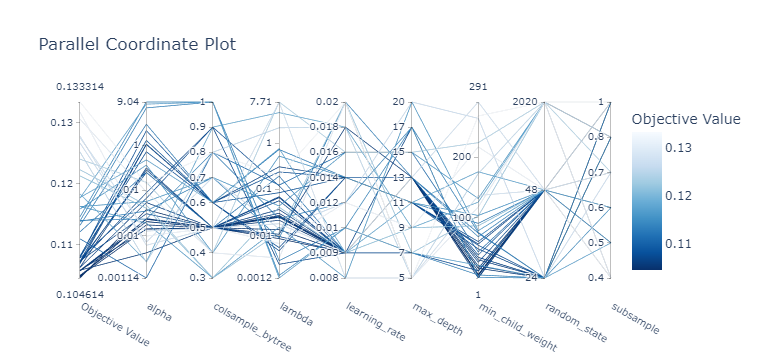

In [175]:
#plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
optuna.visualization.plot_parallel_coordinate(study)

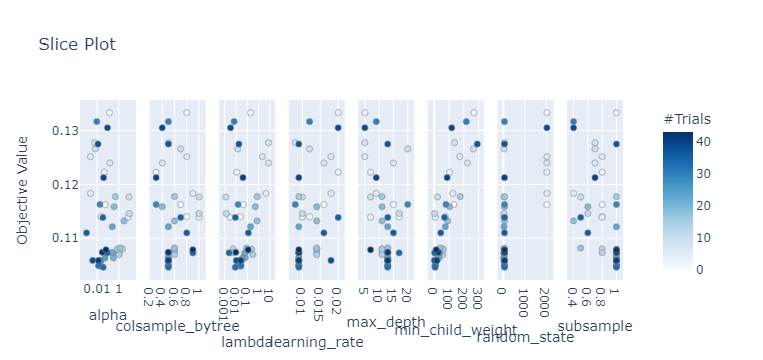

In [177]:
'''plot_slice: shows the evolution of the search. You can see where in the hyperparameter space your search
went and which parts of the space were explored more.'''
optuna.visualization.plot_slice(study)

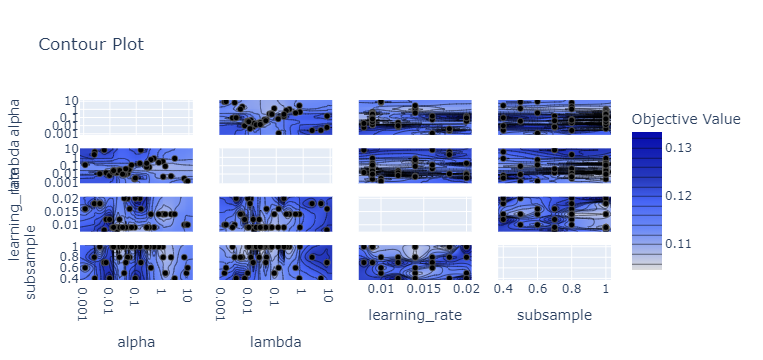

In [178]:
#plot_contour: plots parameter interactions on an interactive chart. You can choose which hyperparameters you would like to explore.
optuna.visualization.plot_contour(study, params=['alpha',
                            #'max_depth',
                            'lambda',
                            'subsample',
                            'learning_rate',
                            'subsample'])

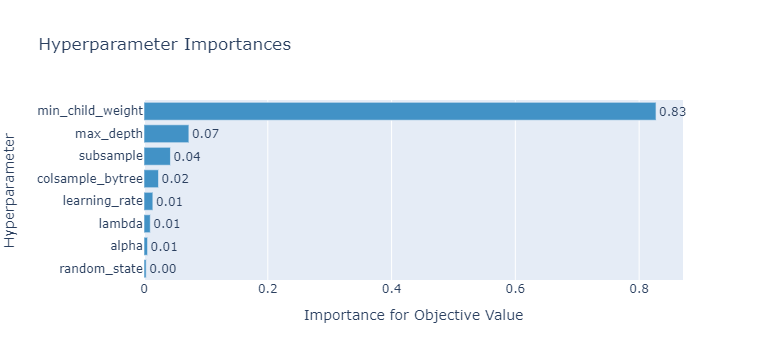

In [179]:
#Visualize parameter importances.
optuna.visualization.plot_param_importances(study) #so cool

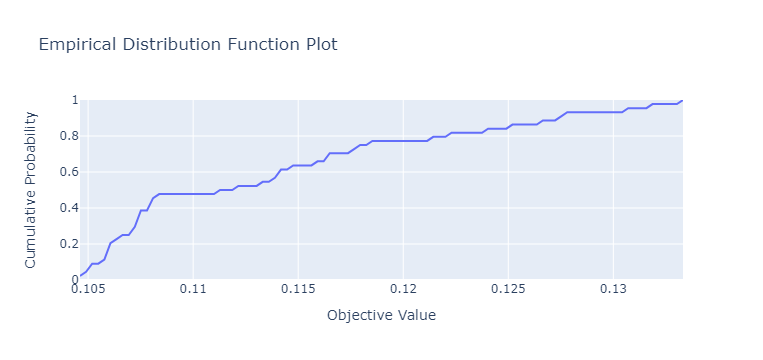

In [180]:
#Visualize empirical distribution function
optuna.visualization.plot_edf(study)

In [183]:
model = xgb.XGBRegressor(tree_method = "gpu_hist",single_precision_histogram=True, gpu_id=0, **study.best_trial.params)
model.fit(X_train_prc,y_train)
y_pred_ = model.predict(X_test_prc)
used_car_df_results = populate_results_df(y_test, y_pred_, 'Optuna XGBReg', used_car_df_results)
used_car_df_results

model          rmse        r2       mape
0             Baseline   9719.772060 -0.000135  56.541225
1      defaults XGBReg   2376.507359  0.940211   8.086443
2  GridSearchCV XGBReg   2180.355340  0.949673   7.184241
3      Hyperopt XGBReg   3489.333523  0.871106  11.288053
4        Optuna XGBReg  19090.832980 -2.858303  97.381728
5        Optuna XGBReg  19090.832980 -2.858303  97.381728

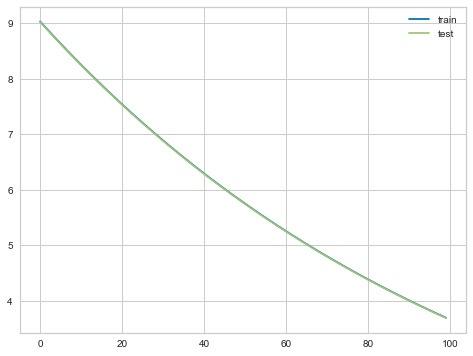

In [189]:
model.fit(X_train_prc, y_train, eval_metric='rmse', eval_set=evalset, verbose=0)
results = model.evals_result()

plt.figure(figsize=(8,6))
# plot learning curves
plt.plot(results['validation_0']['rmse'], label='train')
plt.plot(results['validation_1']['rmse'], label='test')
plt.legend()
plt.show()

In [ ]:
# okay I see. way overfitting it seems. 

# choose params from a trial that appeared to have higher error

In [192]:
study.trials_dataframe().value.min(),study.trials_dataframe().value.max()

(0.10461401338284207, 0.13331438090399425)

In [195]:
study.trials_dataframe()[study.trials_dataframe().value>0.11].sort_values('value').head()

number     value             datetime_start          datetime_complete  \
36      36  0.111006 2022-01-25 18:35:13.466979 2022-01-25 18:36:35.051112   
23      23  0.112147 2022-01-25 18:04:08.205921 2022-01-25 18:05:27.401002   
18      18  0.113217 2022-01-25 17:56:18.418498 2022-01-25 17:57:10.486877   
35      35  0.113868 2022-01-25 18:33:53.947603 2022-01-25 18:35:13.463980   
4        4  0.113912 2022-01-25 17:43:47.225910 2022-01-25 17:44:20.474045   

                 duration  params_alpha  params_colsample_bytree  \
36 0 days 00:01:21.584133      0.001140                      0.8   
23 0 days 00:01:19.195081      0.249083                      0.5   
18 0 days 00:00:52.068379      2.900293                      0.6   
35 0 days 00:01:19.516377      0.034812                      0.7   
4  0 days 00:00:33.248135      6.692947                      1.0   

    params_lambda  params_learning_rate  params_max_depth  \
36       0.123131                 0.016                15   
23       0.192631                 0.009                13   
18       0.723389                 0.014                11   
35       0.008762                 0.020                13   
4        0.002864                 0.010                 7   

    params_min_child_weight  params_random_state  params_subsample     state  
36                       44                   48               0.6  COMPLETE  
23                       75                   24               1.0  COMPLETE  
18                       91                   48               0.4  COMPLETE  
35                       69                   48               0.5  COMPLETE  
4                         6                   24               0.8  COMPLETE

In [216]:
# lets just randomly select trial 36 and see if that gives a smaller error to confirm our suspicions. 

params_optuna_trial_36 = study.trials_dataframe().iloc[36,5:-1].to_dict()
params_optuna_trial_36
corrects_names_params_36 = {}
for k,v in params_optuna_trial_36.items():
    new_key = '_'.join([x for x in k.split('_') if x != 'params'])
    print(new_key)
    corrects_names_params_36[new_key] = v
    

alpha
colsample_bytree
lambda
learning_rate
max_depth
min_child_weight
random_state
subsample


In [217]:
model = xgb.XGBRegressor(tree_method = "gpu_hist",single_precision_histogram=True, gpu_id=0, **corrects_names_params_36)
model.fit(X_train_prc,y_train)
y_pred_ = model.predict(X_test_prc)
used_car_df_results = populate_results_df(y_test, y_pred_, 'Optuna XGBReg', used_car_df_results)
used_car_df_results

model          rmse        r2       mape
0             Baseline   9719.772060 -0.000135  56.541225
1      defaults XGBReg   2376.507359  0.940211   8.086443
2  GridSearchCV XGBReg   2180.355340  0.949673   7.184241
3      Hyperopt XGBReg   3489.333523  0.871106  11.288053
4        Optuna XGBReg  16769.900102 -1.977196  83.397093

In [220]:
# actually lets try one last thing. taking the first or second trial - before it massively and grossly overfits. 
# lets just randomly select trial 36 and see if that gives a smaller error to confirm our suspicions. 

params_optuna_trial_36 = study.trials_dataframe().iloc[0,5:-1].to_dict()
params_optuna_trial_36
corrects_names_params_36 = {}
for k,v in params_optuna_trial_36.items():
    new_key = '_'.join([x for x in k.split('_') if x != 'params'])
    #print(new_key)
    corrects_names_params_36[new_key] = v
model = xgb.XGBRegressor(tree_method = "gpu_hist",single_precision_histogram=True, gpu_id=0, **corrects_names_params_36)
model.fit(X_train_prc,y_train)
y_pred_ = model.predict(X_test_prc)
used_car_df_results = populate_results_df(y_test, y_pred_, 'Optuna XGBReg', used_car_df_results)
used_car_df_results    

alpha
colsample_bytree
lambda
learning_rate
max_depth
min_child_weight
random_state
subsample


model          rmse        r2       mape
0             Baseline   9719.772060 -0.000135  56.541225
1      defaults XGBReg   2376.507359  0.940211   8.086443
2  GridSearchCV XGBReg   2180.355340  0.949673   7.184241
3      Hyperopt XGBReg   3489.333523  0.871106  11.288053
4        Optuna XGBReg  16769.900102 -1.977196  83.397093
5        Optuna XGBReg  18422.704381 -2.592967  93.237389

In [207]:
# the error is EGREGIOUSLY high. omfg. 
# maybe the take-away is the importance of min_child_weight? 
# do a gridsearchcv with min_child_weight from 6 to 50? (based off of what we saw in trials)

In [221]:
# BASIC TUNE PARAMS 

start_time=time.time()

# grid search
xgb_reg = xgb.XGBRegressor(tree_method = "gpu_hist",single_precision_histogram=True, gpu_id=0)

param_grid = {
        'max_depth': [6, 9, 12],
        'learning_rate': [0.03, 0.05, 0.07],
        'n_estimators':[1500, 1800, 2100],
        'min_child_weight' : [4,6,8,10,12,16,20,25,30,36,44]
                               }

kfold = KFold(n_splits=3, shuffle=True, random_state=10)
grid_search = GridSearchCV(xgb_reg, param_grid, scoring="neg_root_mean_squared_error", cv=kfold)
grid_result = grid_search.fit(X_train_prc, y_train, verbose=0)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_[ 'mean_test_score' ]
stds = grid_result.cv_results_[ 'std_test_score' ]
params = grid_result.cv_results_[ 'params' ]

print(time.time()-start_time)

Best: -0.103972 using {'learning_rate': 0.03, 'max_depth': 9, 'min_child_weight': 6, 'n_estimators': 1500}
57776.1175673008


In [222]:
model = xgb.XGBRegressor(tree_method = "gpu_hist",single_precision_histogram=True, gpu_id=0, **grid_result.best_params_)
model.fit(X_train_prc,y_train)
y_pred_ = model.predict(X_test_prc)
used_car_df_results = populate_results_df(y_test, y_pred_, 'GridSearchCV XGBReg w min_child_wt', used_car_df_results)
used_car_df_results

model          rmse        r2       mape
0                            Baseline   9719.772060 -0.000135  56.541225
1                     defaults XGBReg   2376.507359  0.940211   8.086443
2                 GridSearchCV XGBReg   2180.355340  0.949673   7.184241
3                     Hyperopt XGBReg   3489.333523  0.871106  11.288053
4                       Optuna XGBReg  16769.900102 -1.977196  83.397093
5                       Optuna XGBReg  18422.704381 -2.592967  93.237389
6  GridSearchCV XGBReg w min_child_wt   2242.649377  0.946756   7.146633

In [227]:
tpot = TPOTRegressor(verbosity=2, max_time_mins=10, max_eval_time_mins=0.04, population_size=200)
tpot.fit(X_train_prc, y_train)
tpot.score(X_test_prc, y_test)

Imputing missing values in feature set


Optimization Progress:   0%|          | 0/200 [00:00<?, ?pipeline/s]


10.01 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: DecisionTreeRegressor(input_matrix, max_depth=9, min_samples_leaf=7, min_samples_split=14)
Imputing missing values in feature set


-0.03246917793978124

In [228]:
tpot.export('tpot_used_cars_pipeline.py')

In [243]:
#I'm literally just going to drop the rows with nulls since there are like 3 of them in total 
#X_train_prc = pd.DataFrame(X_train_prc)[~pd.DataFrame(X_train_prc).isnull()]
#dont do it gurl

In [286]:
#np.where(np.diff(X_train_prc.index)>1) #3984, 28542, 30453

#imputing the three missing rows instead. Much less damage done. 
X_train_prc = np.where(np.isnan(X_train_prc),0,X_train_prc)
np.where(np.isneginf(X_train_prc)|np.isinf(X_train_prc))

(array([], dtype=int64), array([], dtype=int64))

In [287]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float32)

# I don't understand where any missing or infinite values came from. Did ALL that cleaning and everything was perfect. i guess TODO would be to check for any infinite or NaN values after encoding.
# actually doing this data row delete excercise is a BAD idea. then EVERYTHING comes out of sync. Also converting back to pd DataFrame is a bad idea. Because then the indices go out of whack. Then can't connect to corresponding y_train or untransformed X_train 


In [288]:
#pipeline found a decision tree to fit best! WHAT! almost as good as xgboost?
from sklearn.tree import DecisionTreeRegressor
exported_pipeline = DecisionTreeRegressor(max_depth=9, min_samples_leaf=7, min_samples_split=14)

exported_pipeline.fit(np.float32(X_train_prc), np.float32(y_train))
results = exported_pipeline.predict(X_test_prc)

In [289]:
used_car_df_results = populate_results_df(y_test, results, 'TPOT tree', used_car_df_results)
used_car_df_results

model          rmse        r2       mape
0                            Baseline   9719.772060 -0.000135  56.541225
1                     defaults XGBReg   2376.507359  0.940211   8.086443
2                 GridSearchCV XGBReg   2180.355340  0.949673   7.184241
3                     Hyperopt XGBReg   3489.333523  0.871106  11.288053
4                       Optuna XGBReg  16769.900102 -1.977196  83.397093
5                       Optuna XGBReg  18422.704381 -2.592967  93.237389
6  GridSearchCV XGBReg w min_child_wt   2242.649377  0.946756   7.146633
7                           TPOT tree   3413.939177  0.876106  12.973127

In [ ]:
# decision tree is by far the simplest model and gives better results than optuns :')

In [290]:
##### ### winning_model ### #####
params = {'learning_rate': 0.07, 'max_depth': 6, 'n_estimators': 2100}

model = xgb.XGBRegressor(tree_method = "gpu_hist",single_precision_histogram=True, gpu_id=0, **params)
model.fit(X_train_prc,y_train)
y_pred_ = model.predict(X_test_prc)

## Winning model evaluation

In [ ]:
# we first do scaled investigation as whatever, this is inbuilt with a cool library


Prediction Error Plot



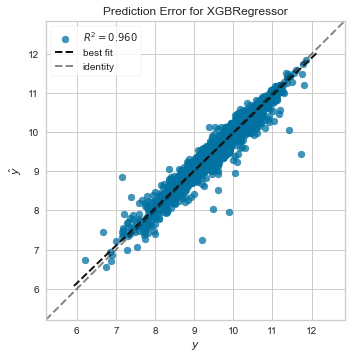

PredictionError(ax=<AxesSubplot:title={'center':'Prediction Error for XGBRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>,
                estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                       colsample_bylevel=1, colsample_bynode=1,
                                       colsample_bytree=1,
                                       enable_categorical=False, gamma=0,
                                       gpu_id=0, importance_type=None,
                                       interaction_constraints='',
                                       learning_rate=0.07, max_delta_step=0,
                                       max_depth=6, min_child_weight=1,
                                       missing=nan, monotone_constraints='()',
                                       n_estimators=2100, n_jobs=12,
                                       num_parallel_tree=1, predictor='auto',
                                       random_state=0, reg_alpha=0,
           

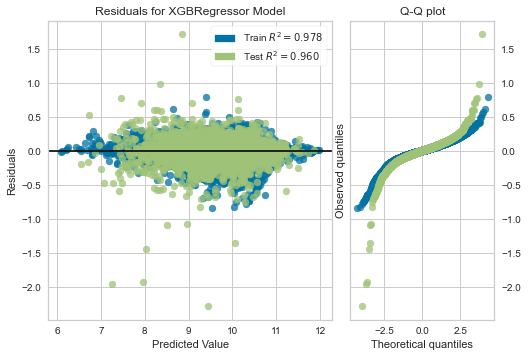

AttributeError: 'XGBRegressor' object has no attribute 'line_color'

In [293]:

# Making the Prediction Error Plot
print("\nPrediction Error Plot\n")
print(prediction_error(model, X_train_prc, y_train, X_test_prc, y_test))
## NOTE! this would be v cool to do with non-scaled version to see where the predictions are coming up correctly / incorrectly

# Making the Residuals Plot
print("\nResiduals Plot\n")
print(residuals_plot(model, X_train_prc, y_train, X_test_prc, y_test, qqplot=True, hist=False))

In [295]:
# we see from the above graph that test residuals are (of course) larger than train. But let's investigate the examples where this is particularly pronounced
# negative residual: forecast < actual ---> resid=(yhat-y)
X_test[(y_pred_ - y_test)<-1]
#fair enough. So the values that aren't being learned are funny models with very little representation
#also there are very few of them so I'm kind of not stressing. Model is underpredicting price of these.

model    year transmission   mileage fuelType    tax   mpg  \
93301       Viva  2019.0       Manual      10.0   Petrol  150.0  46.3   
14130   2 Series  2015.0    Semi-Auto   33419.0   Diesel   20.0  68.9   
70411      Karoq  2019.0    Automatic    3764.0   Petrol  145.0  40.9   
64231    M Class  2004.0    Automatic  121000.0   Diesel  325.0  29.7   
19149   1 Series  2001.0       Manual   22633.0   Petrol  125.0  53.3   
93094      Astra  2007.0       Manual  106000.0   Petrol  200.0  43.5   
19669         Z3  2002.0    Automatic   16500.0   Petrol  325.0  29.4   

       engineSize      make  
93301         1.0  vauxhall  
14130         2.0       bmw  
70411         1.5     skoda  
64231         2.7      merc  
19149         0.0       bmw  
93094         1.6  vauxhall  
19669         2.2       bmw

Text(0, 0.5, 'true price')

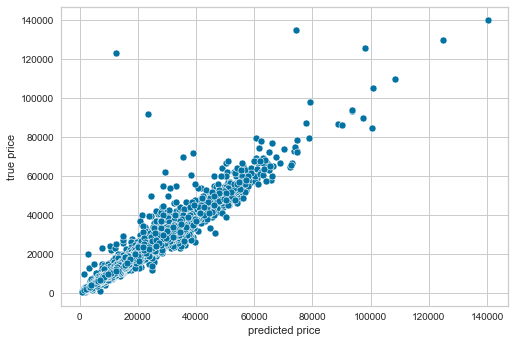

In [297]:
# okay now we plot with unscaled data. 

sns.scatterplot(np.exp(y_pred_), np.exp(y_test))
plt.xlabel('predicted price')
plt.ylabel('true price')

In [ ]:
#looks really good. 
#so we've looked at those few very funny instances where model quite drastically underpredicts. 

Text(0, 0.5, 'prediction residual')

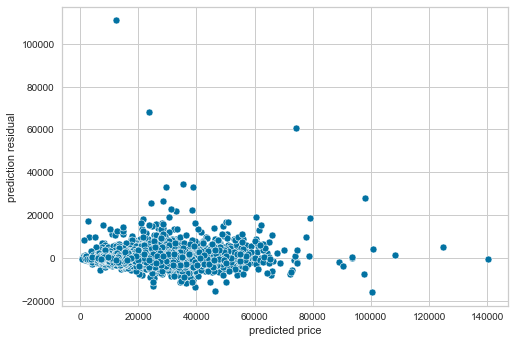

In [299]:
# residuals vs fitted (predicted?) i.e. is there any particular range of values where residuals larger

sns.scatterplot(np.exp(y_pred_), np.exp(y_test)-np.exp(y_pred_))
plt.xlabel('predicted price')
plt.ylabel('prediction residual') #interesting to see that the model slightly underpredicts

In [304]:
np.std(np.exp(y_test)-np.exp(y_pred_))

2241.3520187674226

In [306]:
# seems like between 20000 and 40000 there are more (over?) predictions. 
# its actually kind of cool to see that for high prices (which are the tail, the model doesn't do badly at all)

#so look at 20000-40000 where resid > 0
c1 = (np.exp(y_test) >20000)&(np.exp(y_test) <40000)
c2 = np.exp(y_test)-np.exp(y_pred_) > 2000

over_predicted_df = X_test[c1&c2]

<AxesSubplot:>

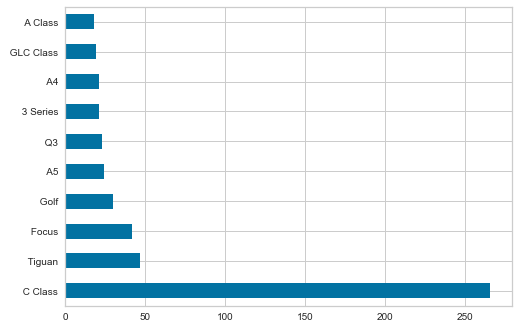

In [311]:
over_predicted_df.model.value_counts().head(10).plot(kind='barh')
# a lot of the CClass.  

<AxesSubplot:>

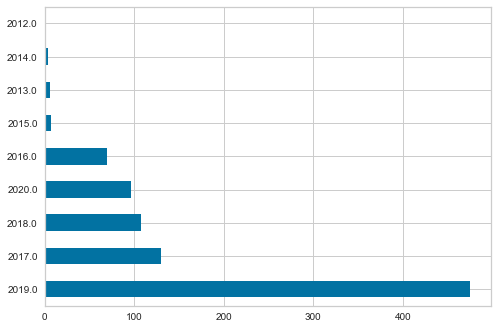

In [313]:
over_predicted_df.year.value_counts().head(10).plot(kind='barh')
# 2019 CClass?

In [324]:
models = over_predicted_df.model.value_counts().head(4).index

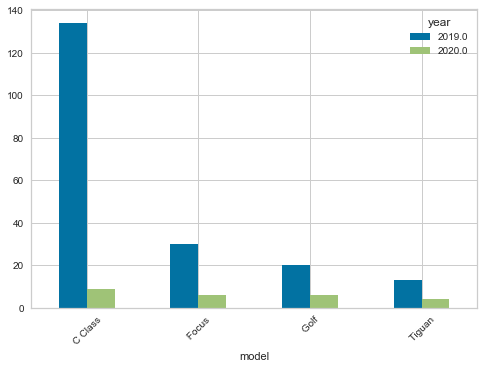

In [325]:
# Creating crosstab
crosstb = pd.crosstab(over_predicted_df[over_predicted_df.model.isin(models)].model, over_predicted_df.year).iloc[:,6:]
 
# Creating barplot
barplot = crosstb.plot.bar(rot=45)

In [328]:
# C Class of 2019 for sure. 
resid = np.exp(y_test)-np.exp(y_pred_)
X_test['resid'] = resid
X_test = X_test.drop('make',axis=1)
c1 = X_test.model == models[0]
c2 = X_test.year == 2019
X_test[c1&c2]


model    year transmission  mileage fuelType         tax   mpg  \
22938   C Class  2019.0       Manual   7410.0   Diesel  169.166667  28.0   
79749   C Class  2019.0    Semi-Auto  13864.0   Diesel  145.410448  28.0   
57948   C Class  2019.0    Automatic   3946.0   Diesel  145.000000  57.7   
59753   C Class  2019.0    Semi-Auto   1023.0   Petrol  145.000000  44.1   
79592   C Class  2019.0    Semi-Auto   2440.0   Diesel  145.410448  28.0   
...         ...     ...          ...      ...      ...         ...   ...   
79355   C Class  2019.0    Automatic  14923.0   Diesel  145.080645  28.0   
23938   C Class  2019.0    Semi-Auto  15337.0   Petrol   62.000000  28.0   
80485   C Class  2019.0    Semi-Auto   6519.0   Petrol  145.173872  28.0   
61300   C Class  2019.0    Semi-Auto   1000.0   Petrol  145.000000  42.2   
59791   C Class  2019.0    Semi-Auto   5230.0   Diesel  145.000000  61.4   

       engineSize        resid  
22938         1.6  1151.232422  
79749         2.0   -86.343750  
57948         2.0  -889.837891  
59753         1.5  5775.673828  
79592         2.0  2140.460937  
...           ...          ...  
79355         2.0  -729.667969  
23938         1.5    69.035156  
80485         2.0 -1306.117187  
61300         2.0  1879.404297  
59791         2.0  1054.675781  

[733 rows x 9 columns]

In [329]:
X_test[c1&c2].sort_values('resid') #but like. what do i do with these now

model    year transmission  mileage fuelType         tax   mpg  \
80740   C Class  2019.0    Automatic    428.0   Petrol  145.173872  28.0   
80711   C Class  2019.0    Semi-Auto   1000.0   Petrol  145.173872  28.0   
21305   C Class  2019.0    Automatic   8500.0   Diesel  374.375000  28.0   
80157   C Class  2019.0    Automatic   1090.0   Petrol  145.173872  28.0   
80174   C Class  2019.0    Automatic    608.0   Petrol  145.173872  28.0   
...         ...     ...          ...      ...      ...         ...   ...   
78915   C Class  2019.0    Automatic   5654.0   Petrol  145.184843  28.0   
80581   C Class  2019.0    Semi-Auto   1000.0   Petrol  145.173872  28.0   
79086   C Class  2019.0    Automatic   8011.0   Petrol  145.184843  28.0   
80871   C Class  2019.0    Semi-Auto   7580.0   Petrol  145.173333  28.0   
80031   C Class  2019.0    Automatic   1079.0   Petrol  145.173872  28.0   

       engineSize         resid  
80740         2.0 -11496.316406  
80711         2.0 -11068.753906  
21305         2.0 -10053.375000  
80157         2.0  -9465.777344  
80174         2.0  -9336.316406  
...           ...           ...  
78915         2.0  19356.767578  
80581         2.0  22491.246094  
79086         2.0  22870.855469  
80871         2.0  32994.800781  
80031         2.0  34534.222656  

[733 rows x 9 columns]

In [ ]:
#TODO at some point when I feel like it more: cluster on residuals to diagnose

In [330]:
import pickle
pickle.dump(model, open("used_cars_xgboost.pickle.dat", "wb"))

In [345]:
import joblib 
joblib.dump(X_test_prc, 'X_test_prc.joblib')
joblib.dump(y_test, 'y_test.joblib')


['y_test.joblib']

In [344]:
joblib.dump(feature_names, 'feature_names.joblib')

['feature_names.joblib']

In [357]:
preprocessor.transformers_[2][1].named_steps['encoder'].category_mapping

[{'col': 0,
  'mapping': Semi-Auto    1
  Automatic    2
  Manual       3
  Other        4
  NaN         -2
  dtype: int64,
  'data_type': dtype('O')},
 {'col': 1,
  'mapping': Diesel      1
  Petrol      2
  Hybrid      3
  Other       4
  Electric    5
  NaN        -2
  dtype: int64,
  'data_type': dtype('O')}]

In [367]:
preprocessor.transformers_[2][1].named_steps['encoder'].mapping


[{'col': 0,
  'mapping':     0_1  0_2  0_3  0_4
   1    1    0    0    0
   2    0    1    0    0
   3    0    0    1    0
   4    0    0    0    1
  -1    0    0    0    0
  -2    0    0    0    0},
 {'col': 1,
  'mapping':     1_1  1_2  1_3  1_4  1_5
   1    1    0    0    0    0
   2    0    1    0    0    0
   3    0    0    1    0    0
   4    0    0    0    1    0
   5    0    0    0    0    1
  -1    0    0    0    0    0
  -2    0    0    0    0    0}]

In [371]:
(used_car_df.transmission=='Manual').sum()/used_car_df.shape[0]

0.5596421643342109

In [388]:
pd.DataFrame(X_train_prc, columns=feature_names).corr().loc['engineSize'].sort_values(ascending=False)

engineSize        1.000000
fuelType_1        0.461664
transmission_1    0.307668
transmission_2    0.271902
tax               0.267985
mileage           0.099621
fuelType_3        0.034495
model            -0.001983
transmission_4   -0.003030
fuelType_5       -0.003996
fuelType_4       -0.013667
make             -0.019138
year             -0.036025
mpg              -0.266626
fuelType_2       -0.468397
transmission_3   -0.484538
Name: engineSize, dtype: float64

<AxesSubplot:>

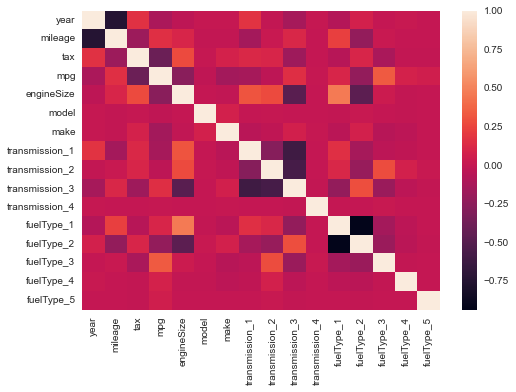

In [374]:
sns.heatmap(pd.DataFrame(X_train_prc, columns=feature_names).corr())

In [391]:
correlated_df = pd.DataFrame(X_train_prc, columns=feature_names).corr().abs()>0.6
correlated_df.sum()[correlated_df.sum() > 1]

year              2
mileage           2
transmission_1    2
transmission_3    2
fuelType_1        2
fuelType_2        2
dtype: int64

In [395]:
correlated_df.loc[['year', 'mileage', 'transmission_1', 'transmission_3', 'fuelType_1', 'fuelType_2'],['year', 'mileage', 'transmission_1', 'transmission_3', 'fuelType_1', 'fuelType_2']].astype(int)

year  mileage  transmission_1  transmission_3  fuelType_1  \
year               1        1               0               0           0   
mileage            1        1               0               0           0   
transmission_1     0        0               1               1           0   
transmission_3     0        0               1               1           0   
fuelType_1         0        0               0               0           1   
fuelType_2         0        0               0               0           1   

                fuelType_2  
year                     0  
mileage                  0  
transmission_1           0  
transmission_3           0  
fuelType_1               1  
fuelType_2               1

In [ ]:
# of course year and mileage are correlated. then the one hot encodings are also. 

In [396]:
X_test

model    year transmission   mileage fuelType         tax   mpg  \
52835     A Class  2019.0    Semi-Auto   14899.0   Diesel  145.000000  68.9   
84658       Focus  2016.0       Manual   47477.0   Diesel  145.277778  38.0   
1663           Q3  2015.0    Semi-Auto   26540.0   Petrol  205.000000  40.4   
18495    1 Series  2015.0    Automatic   47361.0   Petrol  235.000000  37.7   
38073      Fiesta  2016.0       Manual   24256.0   Petrol    0.000000  65.7   
...           ...     ...          ...       ...      ...         ...   ...   
41596      Fiesta  2018.0    Semi-Auto   33846.0   Petrol  145.000000  54.3   
19129    3 Series  2014.0    Automatic  103000.0   Diesel  125.000000  60.1   
70322     Octavia  2019.0    Semi-Auto    2980.0   Petrol  145.000000  57.7   
112532         Up  2016.0       Manual   36429.0   Petrol   20.000000  62.8   
88110       Corsa  2017.0       Manual   40526.0   Petrol   30.000000  55.4   

        engineSize       resid  
52835          1.5  482.763672  
84658          2.0  513.929688  
1663           2.0  -68.359375  
18495          3.0 -404.647461  
38073          1.0  741.685547  
...            ...         ...  
41596          1.0 -793.260742  
19129          2.0  324.050781  
70322          1.5 -942.117187  
112532         1.0 -121.948730  
88110          1.4 -503.634277  

[17321 rows x 9 columns]

<AxesSubplot:>

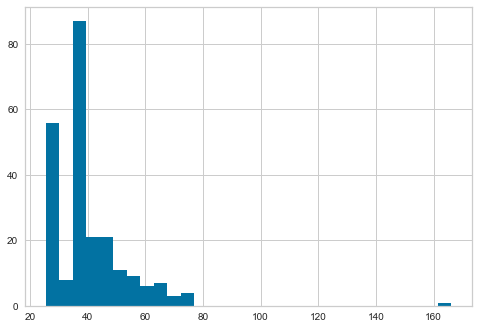

In [399]:
resid_scaled = y_test-y_pred_
X_test[np.abs(resid_scaled)>0.3].mpg.hist(bins=30)

In [410]:
# so mpg values < 40 have larger residuals

c1 = X_test.mpg < 40
c2 = np.abs(resid_scaled)>0.3

pd.crosstab(X_test[c1&c2].model,X_test[c1&c2].year).loc[[' C Class',' Focus']].iloc[:,-5:]

year      2016.0  2017.0  2018.0  2019.0  2020.0
model                                           
 C Class       8       6       3      21       1
 Focus         8      31      10       8       0

In [408]:
pd.crosstab(X_test[c1&c2].model,X_test[c1&c2].year).iloc[:,-5:].index

Index([' 3 Series', ' A1', ' A3', ' A5', ' A7', ' C Class', ' C-MAX',
       ' Caravelle', ' E Class', ' Focus', ' Golf', ' Kuga', ' M Class', ' M2',
       ' Mokka X', ' Mondeo', ' Passat', ' Q7', ' R8', ' Roomster', ' S Class',
       ' S8', ' SL CLASS', ' SLK', ' Touran', ' Verso', ' X5', ' Z3',
       ' Zafira', '230'],
      dtype='object', name='model')

In [412]:
X_test[c1&c2].sort_values('resid',ascending=False)

model    year transmission  mileage fuelType         tax   mpg  \
3350         R8  2019.0    Automatic   1000.0   Petrol  145.000000  32.8   
80031   C Class  2019.0    Automatic   1079.0   Petrol  145.173872  28.0   
80871   C Class  2019.0    Semi-Auto   7580.0   Petrol  145.173333  28.0   
79082   C Class  2017.0    Automatic  26000.0   Petrol  145.184843  28.0   
79086   C Class  2019.0    Automatic   8011.0   Petrol  145.184843  28.0   
...         ...     ...          ...      ...      ...         ...   ...   
10171        S8  2015.0    Automatic  40102.0   Petrol  325.000000  30.1   
80711   C Class  2019.0    Semi-Auto   1000.0   Petrol  145.173872  28.0   
9537         Q7  2014.0    Semi-Auto  34000.0   Diesel  555.000000  28.5   
80740   C Class  2019.0    Automatic    428.0   Petrol  145.173872  28.0   
64078   S Class  2016.0    Automatic  15000.0   Petrol  300.000000  33.6   

       engineSize         resid  
3350          5.2  60626.992188  
80031         2.0  34534.222656  
80871         2.0  32994.800781  
79082         2.0  25540.466797  
79086         2.0  22870.855469  
...           ...           ...  
10171         4.0 -10800.894531  
80711         2.0 -11068.753906  
9537          4.1 -11297.835938  
80740         2.0 -11496.316406  
64078         4.7 -15564.480469  

[157 rows x 9 columns]

In [417]:
# cclass 2019 - larger resid
np.where(X_test.index==80031)

(array([9514], dtype=int64),)